In [2]:
import numpy as np
import matplotlib.pyplot as plt

# 畳み込みニューラルネットワーク（CNN）とは

- 全結合ニューラルネットワーク 「Affine - ReLU」
>1. Affineレイヤ（**全結合層**）
>2. 隣接する全てのニューロン間で結合がある（fully-connected）
>3. データの形に関わらず、1次元に変形するため、データ形状に関する、空間的な情報を生かすことができない。<br><br>
- CNN 「Convolution - ReLU - （Pooling）」
>1. Convolutionレイヤ（**畳み込み層**）、Poolingレイヤ（**プーリング層**）
>2. 出力層に近いところは「Affine - ReLU」、出力層は「Affine - Softmax」
>3. **画像**などの形状があるデータを正しく理解できる可能性がある

![画像を表示できません。](image.png)
上段：全結合層によるニューラルネットワーク、下段：CNNによるニューラルネットワーク

# 畳み込み層

畳み込み層の入出力データを**特徴マップ**（**feature map**）、入力データを**入力特徴マップ**（**input feature map**）、出力データを**出力特徴マップ**（**output feature map**）という

## 2次元畳み込み演算

Cocvolutionレイヤ（畳み込み層）では、画像処理のフィルター演算に相当する「**畳み込み演算**」を行う

![画像を表示できません。](image2.png)
1. ウィンドウ（赤四角）内のそれぞれの場所で、フィルター（カーネル）の要素と入力の対応する要素を乗算
2. 和を求める（1と2をまとめて**積和演算**という）
3. ウィンドウを一定間隔でスライドさせ、同様に計算

### パディング・ストライド

ゼロパディング：主に出力サイズ調整のため、周囲を任意幅のピクセルの0で埋める<br>
ストライド：フィルタを適用する位置の間隔

![画像を表示できません。](image3.png)
これは、パディング幅1、ストライド2の例。<br>
基本的に、出力データは進むにつれて小さくなっていくので、パディングによりサイズを大きくするなどする。

### サイズの関係

$$OH=\dfrac{H+2P-FH}{S}+1$$

$$OW=\dfrac{W+2P-FW}{S}+1$$

入力サイズ$(H,W)$　フィルターサイズ$(FH,FW)$　出力サイズ$(OH,OW)$　パディング$P$　ストライド$S$

$OH$、$OW$は自然数の値になるようにパディングやストライドを調整する必要がある。<br>
ディープラーニングの場合、自然数値を取らない時は、最も近い整数に丸めて先へ進む場合がある。

## 3次元畳み込み演算

![画像を表示できません。](image4.png)
チャンネル方向に特徴マップが増えた。ブロックで表すとわかりやすい。

### バッチ処理

![画像を表示できません。](image5.png)
畳み込み演算でも、N個のデータをまとめて与えてバッチ処理ができる。CNNでは、4次元のデータが流れる。

# プーリング層

プーリングは、縦・横方向の空間を小さくする演算。<br>
対象領域から最大値をとるMaxプーリング、平均値をとるAverageプーリングなどがある。<br>
一般に、ウィンドウサイズとストライドは同じ値に設定する。
- **学習パラメータがない**（最大値もしくは平均値を取るだけなどの処理）
- **チャンネル数は変化しない**（チャンネルごとに独立して計算）
- **微小な位置変化にロバスト（頑健）**（入力値の小さなズレに対し、同じような結果を返す）

![画像を表示できません。](image6.png)
ストライド3で３×３のMaxプーリング

# レイヤの実装

## `im2col`データ展開

- `im2col`はバッチも含めた4次元データを2次元に変換する。
- `Numpy`で`for`文を使うと処理が遅くなるため、フィルター（重み）にとって都合の良いように入力データ展開をする`im2col`を利用する。
- メモリを多く消費するが、線形代数ライブラリを有効活用できる。

![画像を表示できません。](image7.png)

`im2col`によって変換した2次元データと、一列に展開した重みの行列計算をする。

In [3]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

また、レイヤの逆伝播の際には`im2col`の逆の操作が必要であるため、`col2im`を以下で実装する。

In [4]:
def col2im(col, input_shape, filter_h, filter_w, stride=1, pad=0):

    N, C, H, W = input_shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1
    col = col.reshape(N, out_h, out_w, C, filter_h, filter_w).transpose(0, 3, 4, 5, 1, 2)

    img = np.zeros((N, C, H + 2*pad + stride - 1, W + 2*pad + stride - 1))
    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            img[:, :, y:y_max:stride, x:x_max:stride] += col[:, :, y, x, :, :]

    return img[:, :, pad:H + pad, pad:W + pad]

## Convolutionレイヤ

In [5]:
class Convolution:
    def __init__(self, W, b, stride=1, pad=0):
        self.W = W
        self.b = b
        self.stride = stride
        self.pad = pad
        
        # 中間データ（backward時に使用）
        self.x = None   
        self.col = None
        self.col_W = None
        
        # 重み・バイアスパラメータの勾配
        self.dW = None
        self.db = None

    def forward(self, x):
        FN, C, FH, FW = self.W.shape
        N, C, H, W = x.shape
        out_h = 1 + int((H + 2*self.pad - FH) / self.stride)
        out_w = 1 + int((W + 2*self.pad - FW) / self.stride)

        col = im2col(x, FH, FW, self.stride, self.pad)
        col_W = self.W.reshape(FN, -1).T # フィルターの展開
        out = np.dot(col, col_W) + self.b
        out = out.reshape(N, out_h, out_w, -1).transpose(0, 3, 1, 2)

        self.x = x
        self.col = col
        self.col_W = col_W

        return out

    def backward(self, dout):
        FN, C, FH, FW = self.W.shape
        dout = dout.transpose(0,2,3,1).reshape(-1, FN)

        self.db = np.sum(dout, axis=0)
        self.dW = np.dot(self.col.T, dout)
        self.dW = self.dW.transpose(1, 0).reshape(FN, C, FH, FW)

        dcol = np.dot(dout, self.col_W.T)
        dx = col2im(dcol, self.x.shape, FH, FW, self.stride, self.pad)

        return dx

**`reshape(xx, -1)`**
- 多次元配列の辻褄が合うようにまとまる

**`transpose()`**
- 0から始まるインデックスを指定すると、多次元配列の順番の軸を入れ替える

## Poolingレイヤ

![画像を表示できません。](image8.png)
`im2col`でデータを展開し、展開した行列に対し、行ごとに最大値を求め、適切な形状に変形する。

In [6]:
class Pooling:
    def __init__(self, pool_h, pool_w, stride=2, pad=0):
        self.pool_h = pool_h
        self.pool_w = pool_w
        self.stride = stride
        self.pad = pad
        
        self.x = None
        self.arg_max = None

    def forward(self, x):
        N, C, H, W = x.shape
        out_h = int(1 + (H - self.pool_h) / self.stride)
        out_w = int(1 + (W - self.pool_w) / self.stride)

        col = im2col(x, self.pool_h, self.pool_w, self.stride, self.pad)
        col = col.reshape(-1, self.pool_h*self.pool_w)

        arg_max = np.argmax(col, axis=1)
        out = np.max(col, axis=1)
        out = out.reshape(N, out_h, out_w, C).transpose(0, 3, 1, 2)

        self.x = x
        self.arg_max = arg_max

        return out

    def backward(self, dout):
        dout = dout.transpose(0, 2, 3, 1)
        
        pool_size = self.pool_h * self.pool_w
        dmax = np.zeros((dout.size, pool_size))
        dmax[np.arange(self.arg_max.size), self.arg_max.flatten()] = dout.flatten()
        dmax = dmax.reshape(dout.shape + (pool_size,)) 
        
        dcol = dmax.reshape(dmax.shape[0] * dmax.shape[1] * dmax.shape[2], -1)
        dx = col2im(dcol, self.x.shape, self.pool_h, self.pool_w, self.stride, self.pad)
        
        return dx

# CNNの実装

「Convolution - ReLU - Pooling - Affine - ReLU - Affine - Softmax」の構成のCNNを実装する。

In [7]:
import pickle
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class SimpleConvNet:
    """
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

=== epoch:1, train acc:0.174, test acc:0.215 ===
=== epoch:2, train acc:0.953, test acc:0.95 ===
=== epoch:3, train acc:0.975, test acc:0.98 ===
=== epoch:4, train acc:0.983, test acc:0.979 ===
=== epoch:5, train acc:0.982, test acc:0.983 ===
=== epoch:6, train acc:0.983, test acc:0.984 ===
=== epoch:7, train acc:0.987, test acc:0.988 ===
=== epoch:8, train acc:0.989, test acc:0.986 ===
=== epoch:9, train acc:0.992, test acc:0.985 ===
=== epoch:10, train acc:0.997, test acc:0.987 ===
=== epoch:11, train acc:0.997, test acc:0.987 ===
=== epoch:12, train acc:0.993, test acc:0.988 ===
=== epoch:13, train acc:0.994, test acc:0.985 ===
=== epoch:14, train acc:0.999, test acc:0.985 ===
=== epoch:15, train acc:0.999, test acc:0.988 ===
=== epoch:16, train acc:0.993, test acc:0.986 ===
=== epoch:17, train acc:0.998, test acc:0.986 ===
=== epoch:18, train acc:0.997, test acc:0.989 ===
=== epoch:19, train acc:0.998, test acc:0.988 ===
=== epoch:20, train acc:0.997, test acc:0.988 ===
===========

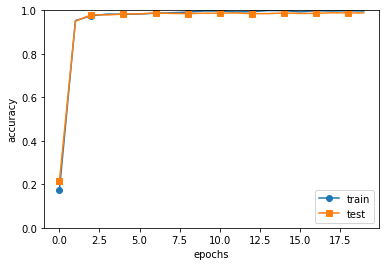

In [8]:
from dataset.mnist import load_mnist
from common.trainer import Trainer

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

max_epochs = 20

network = SimpleConvNet(input_dim=(1,28,28), 
                        conv_param = {'filter_num': 30, 'filter_size': 5, 'pad': 0, 'stride': 1},
                        hidden_size=100, output_size=10, weight_init_std=0.01)
                        
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=max_epochs, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr': 0.001},
                  evaluate_sample_num_per_epoch=1000)
trainer.train()

# パラメータの保存
network.save_params("params.pkl")
print("Saved Network Parameters!")

# グラフの描画
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, trainer.train_acc_list, marker='o', label='train', markevery=2)
plt.plot(x, trainer.test_acc_list, marker='s', label='test', markevery=2)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

# CNNの可視化

以下は、1層目の可視化。学習前のフィルターはランダムに初期化されているが、学習を終えたフィルターは規則性がある。<br>
白から黒へグラデーションするフィルターや、塊のある領域（blob）を持つフィルターへ更新されている。<br>
これは、エッジに反応するフィルターへ更新されていることを示す。

========== 学習前 ==========


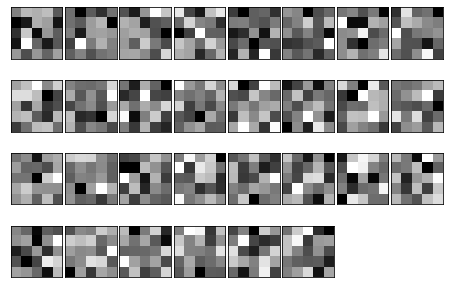

========== 学習後 ==========


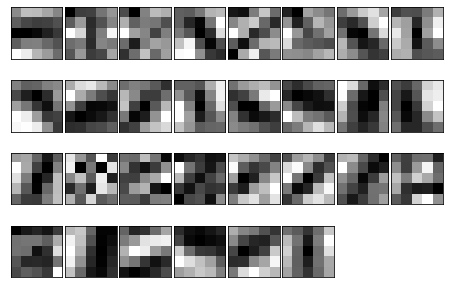

In [9]:
def filter_show(filters, nx=8, margin=3, scale=10):
    """
    c.f. https://gist.github.com/aidiary/07d530d5e08011832b12#file-draw_weight-py
    """
    FN, C, FH, FW = filters.shape
    ny = int(np.ceil(FN / nx))

    fig = plt.figure()
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(FN):
        ax = fig.add_subplot(ny, nx, i+1, xticks=[], yticks=[])
        ax.imshow(filters[i, 0], cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()


network = SimpleConvNet()
# ランダム初期化後の重み
print("========== 学習前 ==========")
filter_show(network.params['W1'])

# 学習後の重み
network.load_params("params.pkl")
print("========== 学習後 ==========")
filter_show(network.params['W1'])

CNNでは、層が深くなるに従って抽出される情報はより抽象化されていく。<br>
例えば、最初の層は単純なエッジに反応し、続いてテクスチャに反応し、そしてより複雑な物体のパーツに反応するようになるといった具合。

# 代表的なCNN

## LeNet

![画像を表示できません。](image9.png)
引用：LeCun, Yann, et al. "Object recognition with gradient-based learning." Shape, contour and grouping in computer vision. Springer, Berlin, Heidelberg, 1999. 319-345.

1998年に提案された、手書き数字を認識するネットワークで、初めてのCNN。<br>
現在主流のCNNとは異なり、活性化関数はReLUではなくSigmoid、Maxプーリングではなくsubsamplingによる中間データサイズ縮小が行われている。

## AlexNet

LeNetと異なる点は以下。
- 活性化関数がReLU
- LRN（Local Response Normalization）という局所的正規化を用いる
- Dropoutを使用する



LeNetから約20年の間、ビッグデータ入手が容易になったことや、大量並列計算を得意とするGPUの普及など、コンピュータ技術に大きな進歩があった。
AlexNetの基本構造はLeNetと大きくは変わらないが、ディープラーニングの発展の大きな原動力になった。